Available cryptocurrencies:
  1. Bitcoin
  2. Ethereum
  3. Cardano
  4. Solana
  5. Polkadot

######################################################################
# CRYPTOCURRENCY PREDICTION SYSTEM
# Coin: SOLANA
# Timestamp: 2025-11-19 09:12:47
######################################################################


Fetching SOLANA data for last 90 days...

✅ Successfully fetched 91 data points
   Date range: 2025-08-22 to 2025-11-19

🔧 Engineering features...
✅ Created 34 features
   Final dataset: 61 samples

🎯 Preparing data for 7-day prediction...
✅ Features: 29
   Samples: 54

🤖 Training ML models...
   Train size: 43 | Test size: 11

   Training Random Forest...
      Train RMSE: $4.49
      Test RMSE:  $26.77
      Test MAE:   $23.56
      Test R²:    -4.4775

   Training Gradient Boosting...
      Train RMSE: $0.00
      Test RMSE:  $16.95
      Test MAE:   $14.93
      Test R²:    -1.1963

✅ Best model: Gradient Boosting

🔮 Predicting 7 days ahead...
   Current Price:    $

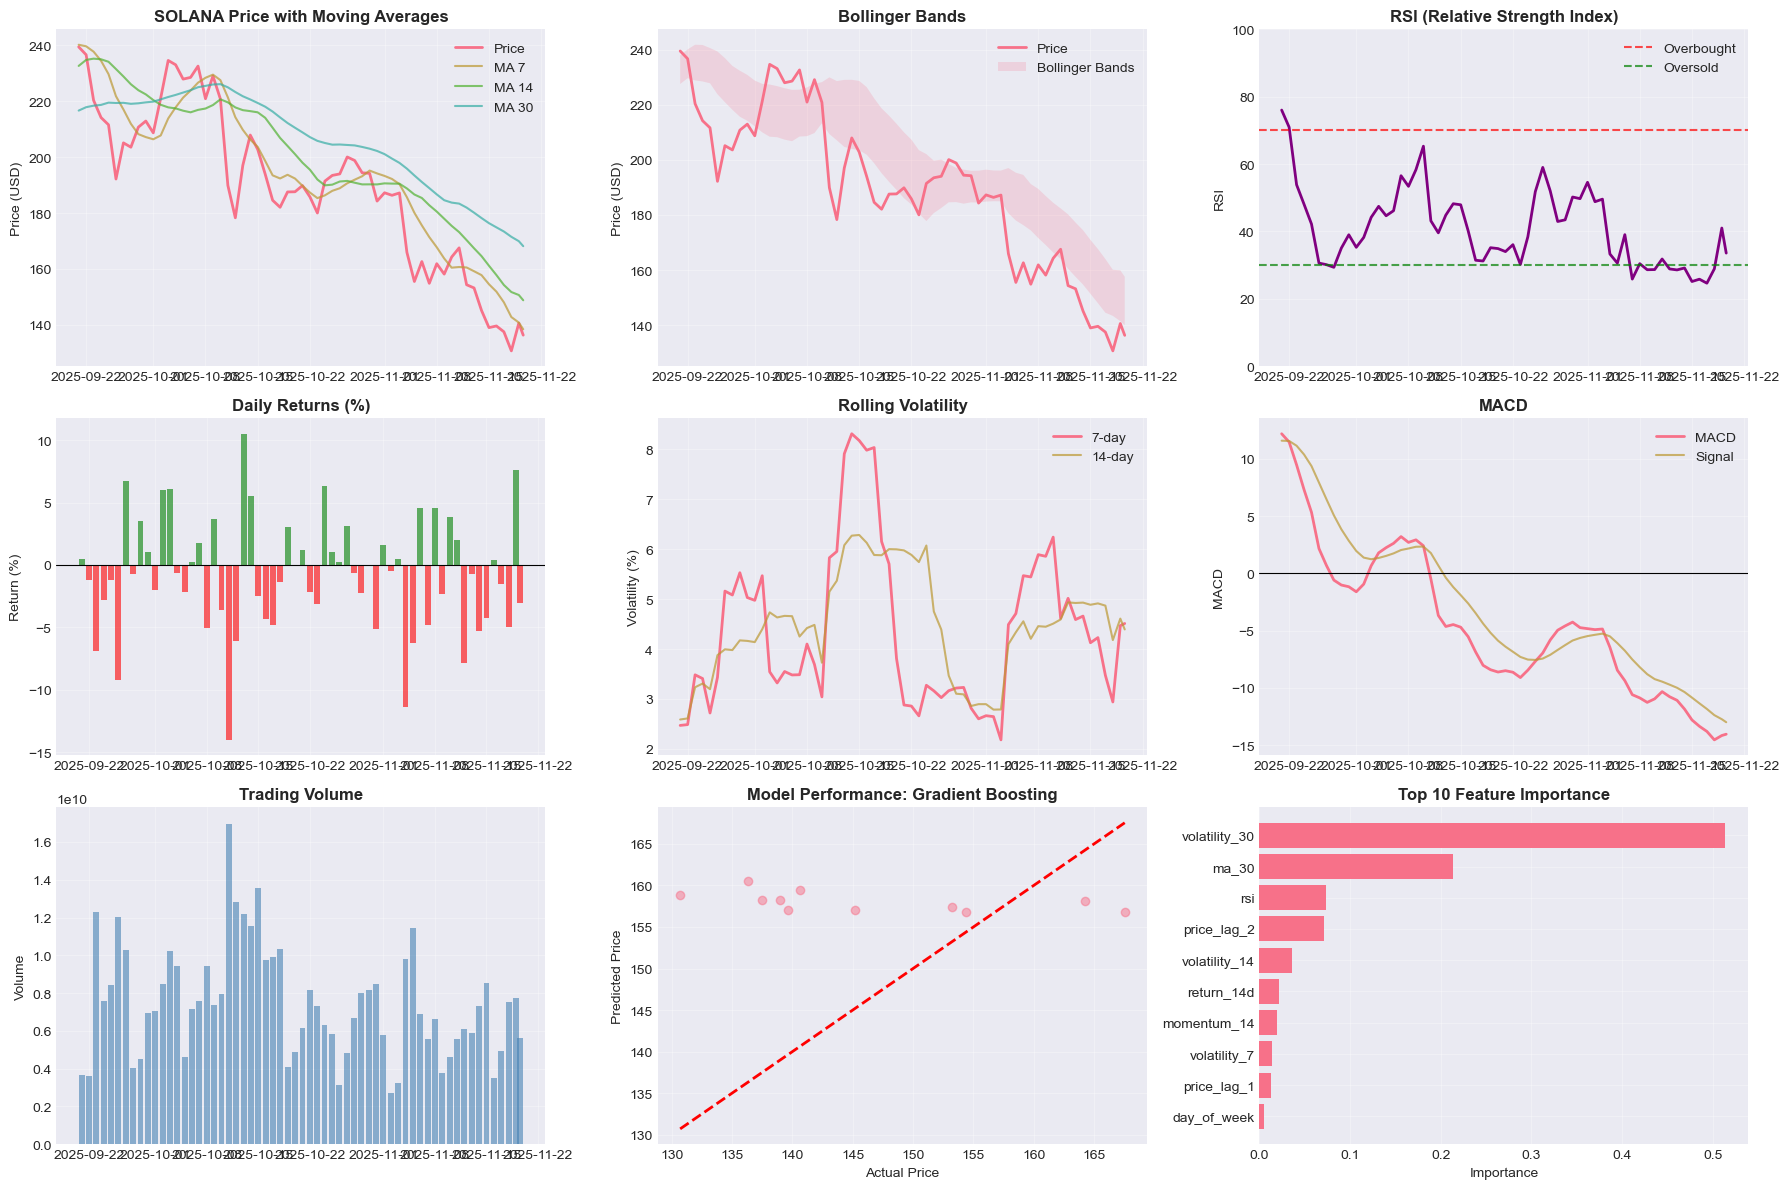

✅ Saved data to: output/solana_data_20251119_091248.csv
✅ Saved report to: output/solana_report_20251119_091248.txt

✅ ANALYSIS COMPLETE!



In [3]:
"""
Real-Time Cryptocurrency Price Prediction System
================================================
Professional-grade crypto analysis with ML predictions
"""

import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class CryptoPredictionSystem:
    """
    Professional cryptocurrency prediction system with ML
    """
    
    def __init__(self, coin_id="bitcoin", days=90):
        self.coin_id = coin_id
        self.days = days
        self.df = None
        self.model = None
        self.scaler = MinMaxScaler()
        
    def fetch_crypto_data(self):
        """Fetch cryptocurrency data from CoinGecko API"""
        
        print(f"\n{'='*70}")
        print(f"Fetching {self.coin_id.upper()} data for last {self.days} days...")
        print(f"{'='*70}\n")
        
        url = f"https://api.coingecko.com/api/v3/coins/{self.coin_id}/market_chart"
        params = {
            "vs_currency": "usd",
            "days": self.days,
            "interval": "daily"
        }
        
        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            
            data = response.json()
            
            # Extract prices, volumes, and market caps
            prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
            volumes = pd.DataFrame(data["total_volumes"], columns=["timestamp", "volume"])
            market_caps = pd.DataFrame(data["market_caps"], columns=["timestamp", "market_cap"])
            
            # Merge all data
            df = prices.merge(volumes, on="timestamp").merge(market_caps, on="timestamp")
            
            # Convert timestamp
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
            df["date"] = df["timestamp"].dt.date
            df = df.sort_values("timestamp").reset_index(drop=True)
            
            print(f"✅ Successfully fetched {len(df)} data points")
            print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
            
            self.df = df
            return df
            
        except requests.exceptions.RequestException as e:
            print(f"❌ Error fetching data: {e}")
            return None
    
    def engineer_features(self):
        """Create advanced technical indicators"""
        
        print("\n🔧 Engineering features...")
        
        df = self.df.copy()
        
        # Basic returns
        df["return_1d"] = df["price"].pct_change() * 100
        df["return_7d"] = df["price"].pct_change(periods=7) * 100
        df["return_14d"] = df["price"].pct_change(periods=14) * 100
        
        # Moving averages
        df["ma_7"] = df["price"].rolling(window=7).mean()
        df["ma_14"] = df["price"].rolling(window=14).mean()
        df["ma_30"] = df["price"].rolling(window=30).mean()
        
        # Exponential moving averages
        df["ema_7"] = df["price"].ewm(span=7, adjust=False).mean()
        df["ema_14"] = df["price"].ewm(span=14, adjust=False).mean()
        
        # Volatility
        df["volatility_7"] = df["return_1d"].rolling(window=7).std()
        df["volatility_14"] = df["return_1d"].rolling(window=14).std()
        df["volatility_30"] = df["return_1d"].rolling(window=30).std()
        
        # Bollinger Bands
        df["bb_upper"] = df["ma_14"] + (2 * df["volatility_14"])
        df["bb_lower"] = df["ma_14"] - (2 * df["volatility_14"])
        df["bb_position"] = (df["price"] - df["bb_lower"]) / (df["bb_upper"] - df["bb_lower"])
        
        # RSI (Relative Strength Index)
        delta = df["price"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df["rsi"] = 100 - (100 / (1 + rs))
        
        # MACD
        ema_12 = df["price"].ewm(span=12, adjust=False).mean()
        ema_26 = df["price"].ewm(span=26, adjust=False).mean()
        df["macd"] = ema_12 - ema_26
        df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()
        
        # Price momentum
        df["momentum_7"] = df["price"] - df["price"].shift(7)
        df["momentum_14"] = df["price"] - df["price"].shift(14)
        
        # Volume indicators
        df["volume_ma_7"] = df["volume"].rolling(window=7).mean()
        df["volume_ratio"] = df["volume"] / df["volume_ma_7"]
        
        # Lag features (previous days' prices)
        for lag in [1, 2, 3, 5, 7]:
            df[f"price_lag_{lag}"] = df["price"].shift(lag)
        
        # Time-based features
        df["day_of_week"] = df["timestamp"].dt.dayofweek
        df["day_of_month"] = df["timestamp"].dt.day
        df["month"] = df["timestamp"].dt.month
        
        # Drop NaN values
        df = df.dropna().reset_index(drop=True)
        
        self.df = df
        
        print(f"✅ Created {len(df.columns)} features")
        print(f"   Final dataset: {len(df)} samples")
        
        return df
    
    def prepare_data_for_ml(self, target_days=7):
        """Prepare data for machine learning"""
        
        print(f"\n🎯 Preparing data for {target_days}-day prediction...")
        
        df = self.df.copy()
        
        # Create target: price change in next N days
        df["target_price"] = df["price"].shift(-target_days)
        df["target_return"] = ((df["target_price"] - df["price"]) / df["price"]) * 100
        
        # Remove rows with no target
        df = df.dropna(subset=["target_price"])
        
        # Select features for model
        feature_cols = [
            "price", "volume", "market_cap",
            "return_1d", "return_7d", "return_14d",
            "ma_7", "ma_14", "ma_30",
            "ema_7", "ema_14",
            "volatility_7", "volatility_14", "volatility_30",
            "bb_position", "rsi", "macd", "macd_signal",
            "momentum_7", "momentum_14",
            "volume_ratio",
            "price_lag_1", "price_lag_2", "price_lag_3", "price_lag_5", "price_lag_7",
            "day_of_week", "day_of_month", "month"
        ]
        
        X = df[feature_cols]
        y = df["target_price"]
        
        print(f"✅ Features: {X.shape[1]}")
        print(f"   Samples: {X.shape[0]}")
        
        return X, y, df
    
    def train_model(self, X, y):
        """Train machine learning models"""
        
        print("\n🤖 Training ML models...")
        
        # Split data (80-20)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )
        
        print(f"   Train size: {len(X_train)} | Test size: {len(X_test)}")
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train models
        models = {
            "Random Forest": RandomForestRegressor(
                n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
            ),
            "Gradient Boosting": GradientBoostingRegressor(
                n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
            )
        }
        
        results = {}
        
        for name, model in models.items():
            print(f"\n   Training {name}...")
            model.fit(X_train_scaled, y_train)
            
            # Predictions
            train_pred = model.predict(X_train_scaled)
            test_pred = model.predict(X_test_scaled)
            
            # Metrics
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            test_mae = mean_absolute_error(y_test, test_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            results[name] = {
                "model": model,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "test_mae": test_mae,
                "test_r2": test_r2,
                "train_pred": train_pred,
                "test_pred": test_pred
            }
            
            print(f"      Train RMSE: ${train_rmse:,.2f}")
            print(f"      Test RMSE:  ${test_rmse:,.2f}")
            print(f"      Test MAE:   ${test_mae:,.2f}")
            print(f"      Test R²:    {test_r2:.4f}")
        
        # Select best model (lowest test RMSE)
        best_model_name = min(results, key=lambda x: results[x]["test_rmse"])
        self.model = results[best_model_name]["model"]
        
        print(f"\n✅ Best model: {best_model_name}")
        
        return results, X_train, X_test, y_train, y_test
    
    def predict_future(self, days_ahead=7):
        """Predict future prices"""
        
        print(f"\n🔮 Predicting {days_ahead} days ahead...")
        
        # Use last row for prediction
        latest_data = self.df.iloc[[-1]].copy()
        
        feature_cols = [
            "price", "volume", "market_cap",
            "return_1d", "return_7d", "return_14d",
            "ma_7", "ma_14", "ma_30",
            "ema_7", "ema_14",
            "volatility_7", "volatility_14", "volatility_30",
            "bb_position", "rsi", "macd", "macd_signal",
            "momentum_7", "momentum_14",
            "volume_ratio",
            "price_lag_1", "price_lag_2", "price_lag_3", "price_lag_5", "price_lag_7",
            "day_of_week", "day_of_month", "month"
        ]
        
        X_latest = latest_data[feature_cols]
        X_latest_scaled = self.scaler.transform(X_latest)
        
        predicted_price = self.model.predict(X_latest_scaled)[0]
        current_price = latest_data["price"].values[0]
        predicted_return = ((predicted_price - current_price) / current_price) * 100
        
        print(f"   Current Price:    ${current_price:,.2f}")
        print(f"   Predicted Price:  ${predicted_price:,.2f}")
        print(f"   Expected Return:  {predicted_return:+.2f}%")
        
        return predicted_price, predicted_return
    
    def generate_signals(self):
        """Generate buy/sell/hold signals"""
        
        print("\n📊 Generating trading signals...")
        
        latest = self.df.iloc[-1]
        
        signals = {
            "momentum": 0,
            "trend": 0,
            "volatility": 0,
            "rsi": 0,
            "macd": 0,
            "bb": 0
        }
        
        # Momentum signal
        if latest["return_7d"] > 5:
            signals["momentum"] = 1
        elif latest["return_7d"] < -5:
            signals["momentum"] = -1
        
        # Trend signal (MA crossover)
        if latest["ema_7"] > latest["ema_14"]:
            signals["trend"] = 1
        else:
            signals["trend"] = -1
        
        # Volatility signal
        if latest["volatility_7"] < 2:
            signals["volatility"] = 1  # Low volatility is good for buying
        elif latest["volatility_7"] > 5:
            signals["volatility"] = -1
        
        # RSI signal
        if latest["rsi"] < 30:
            signals["rsi"] = 1  # Oversold
        elif latest["rsi"] > 70:
            signals["rsi"] = -1  # Overbought
        
        # MACD signal
        if latest["macd"] > latest["macd_signal"]:
            signals["macd"] = 1
        else:
            signals["macd"] = -1
        
        # Bollinger Bands signal
        if latest["bb_position"] < 0.2:
            signals["bb"] = 1  # Near lower band
        elif latest["bb_position"] > 0.8:
            signals["bb"] = -1  # Near upper band
        
        # Overall signal
        total_signal = sum(signals.values())
        
        if total_signal >= 3:
            recommendation = "STRONG BUY 🚀"
        elif total_signal >= 1:
            recommendation = "BUY 📈"
        elif total_signal <= -3:
            recommendation = "STRONG SELL 📉"
        elif total_signal <= -1:
            recommendation = "SELL 🔻"
        else:
            recommendation = "HOLD ⏸️"
        
        print(f"\n{'='*70}")
        print(f"TRADING SIGNALS")
        print(f"{'='*70}")
        for signal_name, value in signals.items():
            icon = "✅" if value > 0 else "❌" if value < 0 else "⚪"
            print(f"  {icon} {signal_name.upper():15s}: {value:+2d}")
        print(f"{'='*70}")
        print(f"  📊 OVERALL SIGNAL: {total_signal:+2d}")
        print(f"  🎯 RECOMMENDATION: {recommendation}")
        print(f"{'='*70}\n")
        
        return signals, recommendation, total_signal
    
    def visualize_comprehensive(self, results, X_test, y_test):
        """Create comprehensive visualizations"""
        
        print("\n📈 Generating visualizations...")
        
        fig = plt.figure(figsize=(18, 12))
        
        # 1. Price history with moving averages
        ax1 = plt.subplot(3, 3, 1)
        ax1.plot(self.df["timestamp"], self.df["price"], label="Price", linewidth=2)
        ax1.plot(self.df["timestamp"], self.df["ma_7"], label="MA 7", alpha=0.7)
        ax1.plot(self.df["timestamp"], self.df["ma_14"], label="MA 14", alpha=0.7)
        ax1.plot(self.df["timestamp"], self.df["ma_30"], label="MA 30", alpha=0.7)
        ax1.set_title(f"{self.coin_id.upper()} Price with Moving Averages", fontweight="bold")
        ax1.set_ylabel("Price (USD)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Bollinger Bands
        ax2 = plt.subplot(3, 3, 2)
        ax2.plot(self.df["timestamp"], self.df["price"], label="Price", linewidth=2)
        ax2.fill_between(self.df["timestamp"], self.df["bb_lower"], 
                         self.df["bb_upper"], alpha=0.2, label="Bollinger Bands")
        ax2.set_title("Bollinger Bands", fontweight="bold")
        ax2.set_ylabel("Price (USD)")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. RSI
        ax3 = plt.subplot(3, 3, 3)
        ax3.plot(self.df["timestamp"], self.df["rsi"], color="purple", linewidth=2)
        ax3.axhline(70, color="red", linestyle="--", alpha=0.7, label="Overbought")
        ax3.axhline(30, color="green", linestyle="--", alpha=0.7, label="Oversold")
        ax3.set_title("RSI (Relative Strength Index)", fontweight="bold")
        ax3.set_ylabel("RSI")
        ax3.set_ylim(0, 100)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Daily Returns
        ax4 = plt.subplot(3, 3, 4)
        colors = ["green" if x > 0 else "red" for x in self.df["return_1d"]]
        ax4.bar(self.df["timestamp"], self.df["return_1d"], color=colors, alpha=0.6)
        ax4.axhline(0, color="black", linewidth=0.8)
        ax4.set_title("Daily Returns (%)", fontweight="bold")
        ax4.set_ylabel("Return (%)")
        ax4.grid(True, alpha=0.3)
        
        # 5. Volatility
        ax5 = plt.subplot(3, 3, 5)
        ax5.plot(self.df["timestamp"], self.df["volatility_7"], label="7-day", linewidth=2)
        ax5.plot(self.df["timestamp"], self.df["volatility_14"], label="14-day", alpha=0.7)
        ax5.set_title("Rolling Volatility", fontweight="bold")
        ax5.set_ylabel("Volatility (%)")
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. MACD
        ax6 = plt.subplot(3, 3, 6)
        ax6.plot(self.df["timestamp"], self.df["macd"], label="MACD", linewidth=2)
        ax6.plot(self.df["timestamp"], self.df["macd_signal"], label="Signal", alpha=0.7)
        ax6.axhline(0, color="black", linewidth=0.8)
        ax6.set_title("MACD", fontweight="bold")
        ax6.set_ylabel("MACD")
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # 7. Volume
        ax7 = plt.subplot(3, 3, 7)
        ax7.bar(self.df["timestamp"], self.df["volume"], alpha=0.6, color="steelblue")
        ax7.set_title("Trading Volume", fontweight="bold")
        ax7.set_ylabel("Volume")
        ax7.grid(True, alpha=0.3)
        
        # 8. Model Predictions vs Actual
        ax8 = plt.subplot(3, 3, 8)
        best_model = min(results, key=lambda x: results[x]["test_rmse"])
        test_pred = results[best_model]["test_pred"]
        ax8.scatter(y_test, test_pred, alpha=0.5)
        ax8.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2)
        ax8.set_title(f"Model Performance: {best_model}", fontweight="bold")
        ax8.set_xlabel("Actual Price")
        ax8.set_ylabel("Predicted Price")
        ax8.grid(True, alpha=0.3)
        
        # 9. Feature Importance
        ax9 = plt.subplot(3, 3, 9)
        model = results[best_model]["model"]
        feature_importance = pd.DataFrame({
            "feature": X_test.columns,
            "importance": model.feature_importances_
        }).sort_values("importance", ascending=False).head(10)
        
        ax9.barh(feature_importance["feature"], feature_importance["importance"])
        ax9.set_title("Top 10 Feature Importance", fontweight="bold")
        ax9.set_xlabel("Importance")
        ax9.invert_yaxis()
        ax9.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        os.makedirs("output", exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"output/{self.coin_id}_analysis_{timestamp}.png"
        plt.savefig(filename, dpi=150, bbox_inches="tight")
        print(f"✅ Saved visualization to: {filename}")
        
        plt.show()
    
    def save_results(self, predicted_price, predicted_return, signals, recommendation):
        """Save analysis results"""
        
        os.makedirs("output", exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save data
        csv_path = f"output/{self.coin_id}_data_{timestamp}.csv"
        self.df.to_csv(csv_path, index=False)
        print(f"✅ Saved data to: {csv_path}")
        
        # Save report
        report_path = f"output/{self.coin_id}_report_{timestamp}.txt"
        with open(report_path, "w") as f:
            f.write(f"{'='*70}\n")
            f.write(f"CRYPTOCURRENCY PREDICTION REPORT\n")
            f.write(f"{'='*70}\n\n")
            f.write(f"Coin: {self.coin_id.upper()}\n")
            f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Data Period: {self.df['date'].min()} to {self.df['date'].max()}\n\n")
            
            latest = self.df.iloc[-1]
            f.write(f"{'='*70}\n")
            f.write(f"CURRENT MARKET DATA\n")
            f.write(f"{'='*70}\n")
            f.write(f"Current Price:    ${latest['price']:,.2f}\n")
            f.write(f"Market Cap:       ${latest['market_cap']:,.0f}\n")
            f.write(f"24h Volume:       ${latest['volume']:,.0f}\n")
            f.write(f"7-day Return:     {latest['return_7d']:+.2f}%\n")
            f.write(f"14-day Return:    {latest['return_14d']:+.2f}%\n")
            f.write(f"Volatility (7d):  {latest['volatility_7']:.2f}%\n")
            f.write(f"RSI:              {latest['rsi']:.2f}\n\n")
            
            f.write(f"{'='*70}\n")
            f.write(f"PRICE PREDICTION (7 days)\n")
            f.write(f"{'='*70}\n")
            f.write(f"Predicted Price:  ${predicted_price:,.2f}\n")
            f.write(f"Expected Return:  {predicted_return:+.2f}%\n\n")
            
            f.write(f"{'='*70}\n")
            f.write(f"TRADING SIGNALS\n")
            f.write(f"{'='*70}\n")
            for signal_name, value in signals.items():
                f.write(f"{signal_name.upper():15s}: {value:+2d}\n")
            f.write(f"\nRECOMMENDATION: {recommendation}\n")
        
        print(f"✅ Saved report to: {report_path}")
    
    def run_full_analysis(self):
        """Run complete analysis pipeline"""
        
        print(f"\n{'#'*70}")
        print(f"# CRYPTOCURRENCY PREDICTION SYSTEM")
        print(f"# Coin: {self.coin_id.upper()}")
        print(f"# Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"{'#'*70}\n")
        
        # Step 1: Fetch data
        if self.fetch_crypto_data() is None:
            return
        
        # Step 2: Engineer features
        self.engineer_features()
        
        # Step 3: Prepare data for ML
        X, y, df_ml = self.prepare_data_for_ml(target_days=7)
        
        # Step 4: Train model
        results, X_train, X_test, y_train, y_test = self.train_model(X, y)
        
        # Step 5: Predict future
        predicted_price, predicted_return = self.predict_future(days_ahead=7)
        
        # Step 6: Generate signals
        signals, recommendation, total_signal = self.generate_signals()
        
        # Step 7: Visualize
        self.visualize_comprehensive(results, X_test, y_test)
        
        # Step 8: Save results
        self.save_results(predicted_price, predicted_return, signals, recommendation)
        
        print(f"\n{'='*70}")
        print(f"✅ ANALYSIS COMPLETE!")
        print(f"{'='*70}\n")


# Main execution
if __name__ == "__main__":
    # You can change the coin and number of days
    COINS = ["bitcoin", "ethereum", "cardano", "solana", "polkadot"]
    
    print("Available cryptocurrencies:")
    for i, coin in enumerate(COINS, 1):
        print(f"  {i}. {coin.capitalize()}")
    
    choice = input("\nEnter coin number (or name): ").strip()
    
    if choice.isdigit() and 1 <= int(choice) <= len(COINS):
        selected_coin = COINS[int(choice) - 1]
    elif choice.lower() in COINS:
        selected_coin = choice.lower()
    else:
        print("Invalid choice. Using Bitcoin as default.")
        selected_coin = "bitcoin"
    
    # Create and run system
    system = CryptoPredictionSystem(coin_id=selected_coin, days=90)
    system.run_full_analysis()


CRYPTOCURRENCY PREDICTION SYSTEM

Available coins:
  1. Bitcoin
  2. Ethereum
  3. Cardano
  4. Solana
  5. Binancecoin

🚀 Starting analysis for ETHEREUM...


######################################################################
# CRYPTO PREDICTION SYSTEM - ETHEREUM
# 2025-11-18 13:54:17
######################################################################


🔄 Fetching REAL-TIME ETHEREUM data...

✅ Fetched 91 data points
   📅 Range: 2025-08-21 to 2025-11-18
   💰 Current: $3,165.33
🔧 Engineering features...
✅ Created 48 features

🎯 Preparing 7-day prediction...
✅ Features: 26 | Samples: 54

🤖 Training models...
   Training Random Forest...
      RMSE: $460.13 | MAE: $412.10 | R²: -5.2224
   Training Gradient Boosting...
      RMSE: $386.37 | MAE: $340.76 | R²: -3.3873

   🏆 Best: Gradient Boosting

🔮 Predicting 7 days ahead...
   💰 Current: $3,165.33
   🎯 Predicted: $3,617.03 (+14.27%)

📊 Generating signals...

TRADING SIGNALS
  🔴 MOMENTUM    : -1
  🔴 TREND       : -1
  ⚪ RSI        

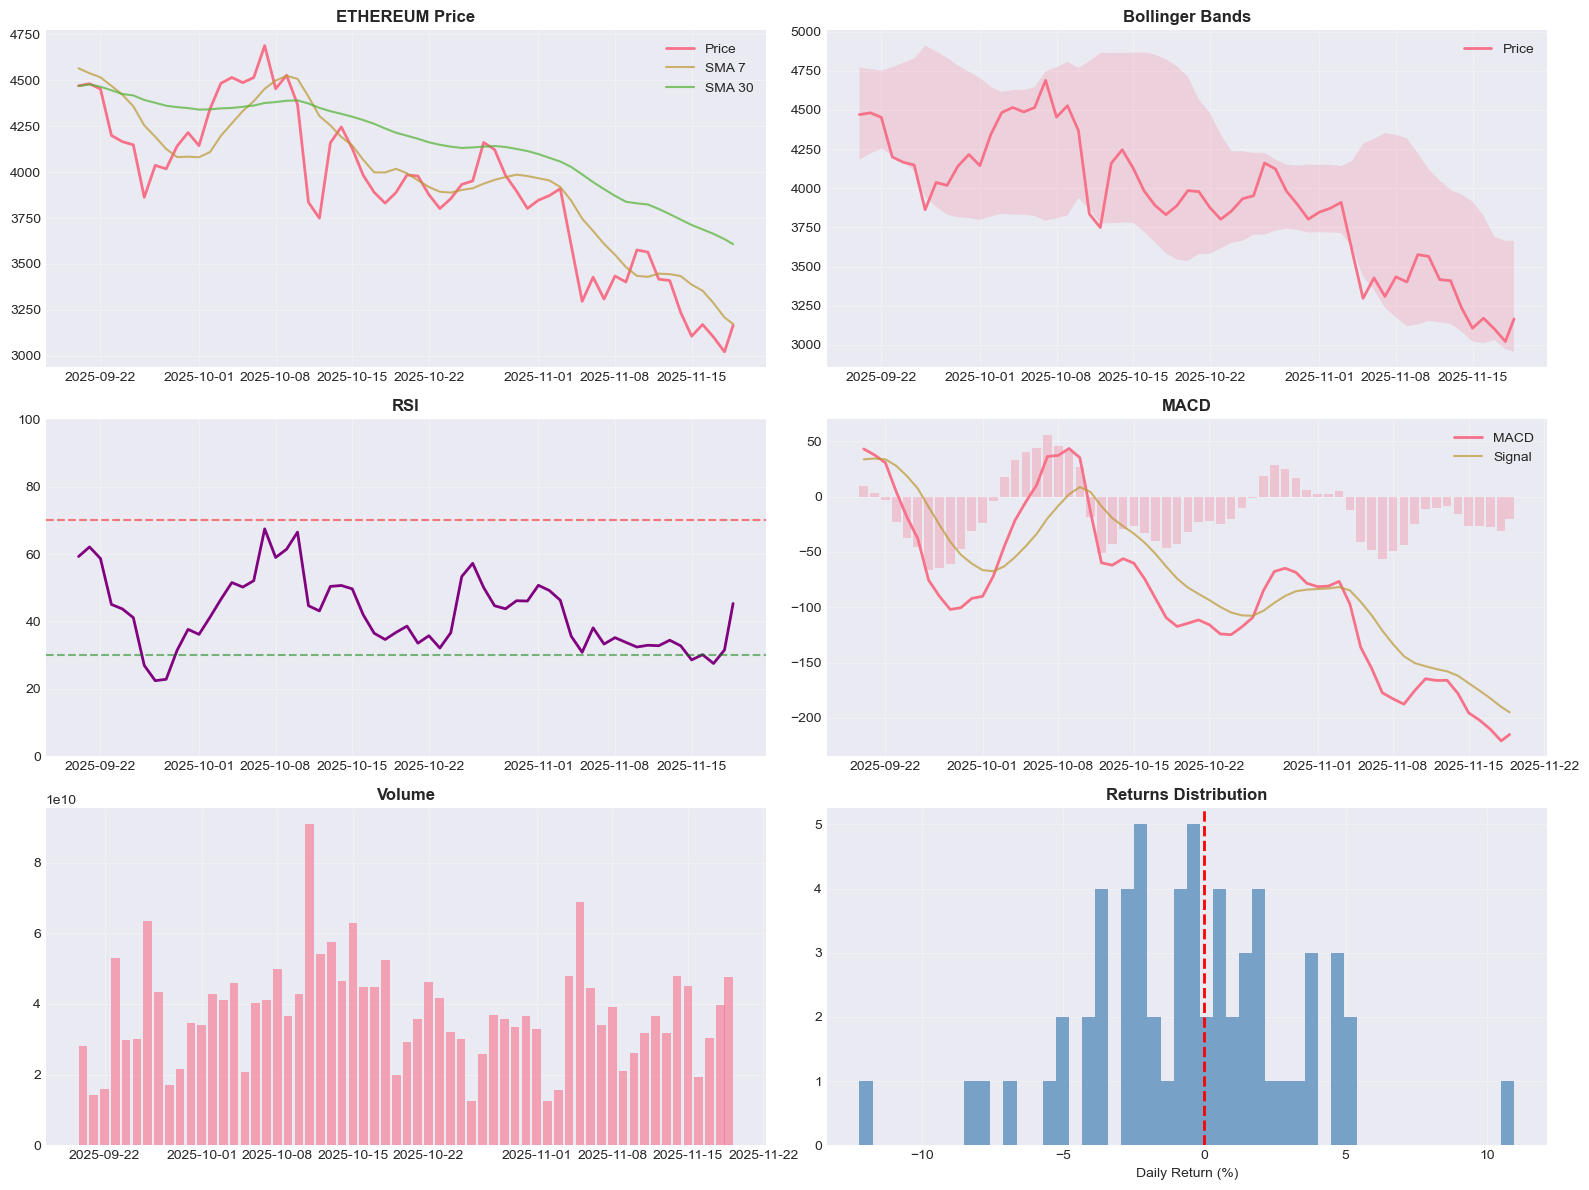


✅ ANALYSIS COMPLETE!


📂 Check 'powerbi_data/' folder for Power BI files
📊 Check 'output/' folder for visualizations



In [4]:
"""
Real-Time Cryptocurrency Prediction System with Power BI Integration
====================================================================
Professional crypto analysis with ML predictions and Power BI exports
"""

import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class CryptoPredictionSystem:
    """Professional cryptocurrency prediction system with ML and Power BI integration"""
    
    def __init__(self, coin_id="bitcoin", days=90):
        self.coin_id = coin_id
        self.days = days
        self.df = None
        self.model = None
        self.scaler = MinMaxScaler()
        self.results = {}
        
    def fetch_crypto_data(self, verbose=True):
        """Fetch real-time cryptocurrency data from CoinGecko API"""
        
        if verbose:
            print(f"\n{'='*70}")
            print(f"🔄 Fetching REAL-TIME {self.coin_id.upper()} data...")
            print(f"{'='*70}\n")
        
        url = f"https://api.coingecko.com/api/v3/coins/{self.coin_id}/market_chart"
        params = {"vs_currency": "usd", "days": self.days, "interval": "daily"}
        
        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            
            # Extract and merge data
            prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
            volumes = pd.DataFrame(data["total_volumes"], columns=["timestamp", "volume"])
            market_caps = pd.DataFrame(data["market_caps"], columns=["timestamp", "market_cap"])
            
            df = prices.merge(volumes, on="timestamp").merge(market_caps, on="timestamp")
            
            # Convert timestamps
            df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
            df["date"] = df["datetime"].dt.date
            df["year"] = df["datetime"].dt.year
            df["month"] = df["datetime"].dt.month
            df["day"] = df["datetime"].dt.day
            df["day_of_week"] = df["datetime"].dt.day_name()
            df["quarter"] = df["datetime"].dt.quarter
            
            df = df.sort_values("timestamp").reset_index(drop=True)
            
            if verbose:
                print(f"✅ Fetched {len(df)} data points")
                print(f"   📅 Range: {df['date'].min()} to {df['date'].max()}")
                print(f"   💰 Current: ${df['price'].iloc[-1]:,.2f}")
            
            self.df = df
            return df
            
        except Exception as e:
            print(f"❌ Error: {e}")
            return None
    
    def engineer_features(self):
        """Create advanced technical indicators"""
        
        print("🔧 Engineering features...")
        df = self.df.copy()
        
        # Returns
        for period in [1, 3, 7, 14, 30]:
            df[f"return_{period}d"] = df["price"].pct_change(periods=period) * 100
        
        # Moving Averages
        for window in [7, 14, 30, 50]:
            df[f"sma_{window}"] = df["price"].rolling(window=window, min_periods=1).mean()
            df[f"ema_{window}"] = df["price"].ewm(span=window, adjust=False).mean()
        
        # Volatility
        for window in [7, 14, 30]:
            df[f"volatility_{window}"] = df["return_1d"].rolling(window=window).std()
        
        # Bollinger Bands
        df["bb_middle"] = df["sma_14"]
        df["bb_std"] = df["price"].rolling(window=14).std()
        df["bb_upper"] = df["bb_middle"] + (2 * df["bb_std"])
        df["bb_lower"] = df["bb_middle"] - (2 * df["bb_std"])
        df["bb_position"] = (df["price"] - df["bb_lower"]) / (df["bb_upper"] - df["bb_lower"])
        
        # RSI
        delta = df["price"].diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss
        df["rsi"] = 100 - (100 / (1 + rs))
        
        # MACD
        ema_12 = df["price"].ewm(span=12, adjust=False).mean()
        ema_26 = df["price"].ewm(span=26, adjust=False).mean()
        df["macd"] = ema_12 - ema_26
        df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()
        df["macd_histogram"] = df["macd"] - df["macd_signal"]
        
        # Momentum
        for period in [3, 7, 14]:
            df[f"momentum_{period}"] = df["price"] - df["price"].shift(period)
        
        # Volume indicators
        df["volume_sma_7"] = df["volume"].rolling(window=7).mean()
        df["volume_ratio"] = df["volume"] / df["volume_sma_7"]
        
        # Lag features
        for lag in [1, 2, 3, 5, 7]:
            df[f"price_lag_{lag}"] = df["price"].shift(lag)
        
        # Trends
        df["trend_bullish"] = (df["ema_7"] > df["ema_14"]).astype(int)
        df["sentiment_score"] = ((df["rsi"] < 30).astype(int) * 2 + 
                                 (df["macd"] > df["macd_signal"]).astype(int))
        
        df = df.dropna().reset_index(drop=True)
        self.df = df
        
        print(f"✅ Created {len(df.columns)} features")
        return df
    
    def prepare_data_for_ml(self, target_days=7):
        """Prepare data for ML"""
        
        print(f"\n🎯 Preparing {target_days}-day prediction...")
        df = self.df.copy()
        
        df["target_price"] = df["price"].shift(-target_days)
        df["target_return"] = ((df["target_price"] - df["price"]) / df["price"]) * 100
        df = df.dropna(subset=["target_price"])
        
        feature_cols = [
            "price", "volume", "market_cap",
            "return_1d", "return_7d", "return_14d",
            "sma_7", "sma_14", "sma_30", "ema_7", "ema_14",
            "volatility_7", "volatility_14",
            "bb_position", "rsi", "macd", "macd_histogram",
            "momentum_7", "momentum_14", "volume_ratio",
            "price_lag_1", "price_lag_3", "price_lag_7",
            "sentiment_score", "month", "day"
        ]
        
        X, y = df[feature_cols], df["target_price"]
        print(f"✅ Features: {X.shape[1]} | Samples: {X.shape[0]}")
        
        return X, y, df
    
    def train_model(self, X, y):
        """Train ML models"""
        
        print("\n🤖 Training models...")
        
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        models = {
            "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
            "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)
        }
        
        results = {}
        for name, model in models.items():
            print(f"   Training {name}...")
            model.fit(X_train_scaled, y_train)
            
            test_pred = model.predict(X_test_scaled)
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            test_mae = mean_absolute_error(y_test, test_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            results[name] = {
                "model": model,
                "test_rmse": test_rmse,
                "test_mae": test_mae,
                "test_r2": test_r2,
                "test_pred": test_pred
            }
            
            print(f"      RMSE: ${test_rmse:,.2f} | MAE: ${test_mae:,.2f} | R²: {test_r2:.4f}")
        
        best_model = min(results, key=lambda x: results[x]["test_rmse"])
        self.model = results[best_model]["model"]
        self.results = results
        
        print(f"\n   🏆 Best: {best_model}")
        return results, X_train, X_test, y_train, y_test
    
    def predict_future(self, days_ahead=7):
        """Predict future prices"""
        
        print(f"\n🔮 Predicting {days_ahead} days ahead...")
        
        latest = self.df.iloc[[-1]]
        feature_cols = [
            "price", "volume", "market_cap",
            "return_1d", "return_7d", "return_14d",
            "sma_7", "sma_14", "sma_30", "ema_7", "ema_14",
            "volatility_7", "volatility_14",
            "bb_position", "rsi", "macd", "macd_histogram",
            "momentum_7", "momentum_14", "volume_ratio",
            "price_lag_1", "price_lag_3", "price_lag_7",
            "sentiment_score", "month", "day"
        ]
        
        X_latest = self.scaler.transform(latest[feature_cols])
        predicted_price = self.model.predict(X_latest)[0]
        current_price = latest["price"].values[0]
        predicted_return = ((predicted_price - current_price) / current_price) * 100
        
        print(f"   💰 Current: ${current_price:,.2f}")
        print(f"   🎯 Predicted: ${predicted_price:,.2f} ({predicted_return:+.2f}%)")
        
        return {
            "current_price": current_price,
            "predicted_price": predicted_price,
            "predicted_return": predicted_return,
            "prediction_date": (datetime.now() + timedelta(days=days_ahead)).strftime("%Y-%m-%d")
        }
    
    def generate_signals(self):
        """Generate trading signals"""
        
        print("\n📊 Generating signals...")
        latest = self.df.iloc[-1]
        
        signals = {
            "momentum": 1 if latest["return_7d"] > 5 else -1 if latest["return_7d"] < -5 else 0,
            "trend": 1 if latest["ema_7"] > latest["ema_14"] else -1,
            "rsi": 2 if latest["rsi"] < 30 else -2 if latest["rsi"] > 70 else 0,
            "macd": 1 if latest["macd"] > latest["macd_signal"] else -1,
            "bollinger": 1 if latest["bb_position"] < 0.3 else -1 if latest["bb_position"] > 0.7 else 0
        }
        
        total = sum(signals.values())
        
        if total >= 3:
            recommendation, action = "STRONG BUY 🚀", "BUY"
        elif total >= 1:
            recommendation, action = "BUY 📈", "BUY"
        elif total <= -3:
            recommendation, action = "STRONG SELL 📉", "SELL"
        elif total <= -1:
            recommendation, action = "SELL 🔻", "SELL"
        else:
            recommendation, action = "HOLD ⏸️", "HOLD"
        
        print(f"\n{'='*70}")
        print("TRADING SIGNALS")
        print(f"{'='*70}")
        for name, val in signals.items():
            icon = "🟢" if val > 0 else "🔴" if val < 0 else "⚪"
            print(f"  {icon} {name.upper():12s}: {val:+2d}")
        print(f"{'='*70}")
        print(f"  📊 TOTAL: {total:+2d}")
        print(f"  🎯 ACTION: {action}")
        print(f"{'='*70}\n")
        
        return {"signals": signals, "total": total, "recommendation": recommendation, "action": action}
    
    def export_for_powerbi(self, prediction_result, signal_result):
        """Export comprehensive Power BI datasets"""
        
        print("\n📊 Exporting for Power BI...")
        os.makedirs("powerbi_data", exist_ok=True)
        
        # 1. Time Series Data (Main historical data)
        timeseries_df = self.df.copy()
        timeseries_df["coin"] = self.coin_id
        timeseries_df["data_timestamp"] = datetime.now()
        
        timeseries_file = f"powerbi_data/{self.coin_id}_timeseries.csv"
        timeseries_df.to_csv(timeseries_file, index=False)
        print(f"   ✅ {timeseries_file}")
        
        # 2. Latest Snapshot (KPIs)
        latest = self.df.iloc[-1]
        snapshot_df = pd.DataFrame([{
            "coin": self.coin_id,
            "update_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "current_price": latest["price"],
            "volume_24h": latest["volume"],
            "market_cap": latest["market_cap"],
            "return_1d": latest["return_1d"],
            "return_7d": latest["return_7d"],
            "return_30d": latest["return_30d"],
            "volatility_7d": latest["volatility_7"],
            "rsi": latest["rsi"],
            "macd": latest["macd"],
            "sentiment_score": latest["sentiment_score"]
        }])
        
        snapshot_file = f"powerbi_data/{self.coin_id}_snapshot.csv"
        snapshot_df.to_csv(snapshot_file, index=False)
        print(f"   ✅ {snapshot_file}")
        
        # 3. Predictions
        pred_df = pd.DataFrame([{
            "coin": self.coin_id,
            "prediction_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "prediction_date": prediction_result["prediction_date"],
            "current_price": prediction_result["current_price"],
            "predicted_price": prediction_result["predicted_price"],
            "predicted_return": prediction_result["predicted_return"]
        }])
        
        pred_file = f"powerbi_data/{self.coin_id}_predictions.csv"
        pred_df.to_csv(pred_file, index=False)
        print(f"   ✅ {pred_file}")
        
        # 4. Trading Signals
        signals_list = []
        for name, val in signal_result["signals"].items():
            signals_list.append({
                "coin": self.coin_id,
                "signal_name": name,
                "signal_value": val,
                "signal_type": "Bullish" if val > 0 else "Bearish" if val < 0 else "Neutral"
            })
        
        signals_df = pd.DataFrame(signals_list)
        signals_file = f"powerbi_data/{self.coin_id}_signals.csv"
        signals_df.to_csv(signals_file, index=False)
        print(f"   ✅ {signals_file}")
        
        # 5. Recommendation
        rec_df = pd.DataFrame([{
            "coin": self.coin_id,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "total_signal": signal_result["total"],
            "recommendation": signal_result["recommendation"],
            "action": signal_result["action"]
        }])
        
        rec_file = f"powerbi_data/{self.coin_id}_recommendation.csv"
        rec_df.to_csv(rec_file, index=False)
        print(f"   ✅ {rec_file}")
        
        # 6. Model Performance
        metrics_list = []
        for model_name, result in self.results.items():
            metrics_list.append({
                "model_name": model_name,
                "rmse": result["test_rmse"],
                "mae": result["test_mae"],
                "r2_score": result["test_r2"]
            })
        
        metrics_df = pd.DataFrame(metrics_list)
        metrics_file = f"powerbi_data/model_performance.csv"
        metrics_df.to_csv(metrics_file, index=False)
        print(f"   ✅ {metrics_file}")
        
        print(f"\n✅ All data exported to powerbi_data/ folder")
        
    def visualize(self):
        """Create comprehensive visualizations"""
        
        print("\n📈 Creating visualizations...")
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        
        # Price with MAs
        axes[0,0].plot(self.df["datetime"], self.df["price"], label="Price", linewidth=2)
        axes[0,0].plot(self.df["datetime"], self.df["sma_7"], label="SMA 7", alpha=0.7)
        axes[0,0].plot(self.df["datetime"], self.df["sma_30"], label="SMA 30", alpha=0.7)
        axes[0,0].set_title(f"{self.coin_id.upper()} Price", fontweight="bold")
        axes[0,0].legend()
        axes[0,0].grid(alpha=0.3)
        
        # Bollinger Bands
        axes[0,1].plot(self.df["datetime"], self.df["price"], label="Price", linewidth=2)
        axes[0,1].fill_between(self.df["datetime"], self.df["bb_lower"], 
                               self.df["bb_upper"], alpha=0.2)
        axes[0,1].set_title("Bollinger Bands", fontweight="bold")
        axes[0,1].legend()
        axes[0,1].grid(alpha=0.3)
        
        # RSI
        axes[1,0].plot(self.df["datetime"], self.df["rsi"], color="purple", linewidth=2)
        axes[1,0].axhline(70, color="red", linestyle="--", alpha=0.5)
        axes[1,0].axhline(30, color="green", linestyle="--", alpha=0.5)
        axes[1,0].set_title("RSI", fontweight="bold")
        axes[1,0].set_ylim(0, 100)
        axes[1,0].grid(alpha=0.3)
        
        # MACD
        axes[1,1].plot(self.df["datetime"], self.df["macd"], label="MACD", linewidth=2)
        axes[1,1].plot(self.df["datetime"], self.df["macd_signal"], label="Signal", alpha=0.7)
        axes[1,1].bar(self.df["datetime"], self.df["macd_histogram"], alpha=0.3)
        axes[1,1].set_title("MACD", fontweight="bold")
        axes[1,1].legend()
        axes[1,1].grid(alpha=0.3)
        
        # Volume
        axes[2,0].bar(self.df["datetime"], self.df["volume"], alpha=0.6)
        axes[2,0].set_title("Volume", fontweight="bold")
        axes[2,0].grid(alpha=0.3)
        
        # Returns Distribution
        axes[2,1].hist(self.df["return_1d"].dropna(), bins=50, alpha=0.7, color="steelblue")
        axes[2,1].axvline(0, color="red", linestyle="--", linewidth=2)
        axes[2,1].set_title("Returns Distribution", fontweight="bold")
        axes[2,1].set_xlabel("Daily Return (%)")
        axes[2,1].grid(alpha=0.3)
        
        plt.tight_layout()
        
        # Save
        os.makedirs("output", exist_ok=True)
        filename = f"output/{self.coin_id}_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(filename, dpi=150, bbox_inches="tight")
        print(f"✅ Saved: {filename}")
        plt.show()
    
    def run_analysis(self):
        """Run complete analysis"""
        
        print(f"\n{'#'*70}")
        print(f"# CRYPTO PREDICTION SYSTEM - {self.coin_id.upper()}")
        print(f"# {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"{'#'*70}\n")
        
        # Pipeline
        if self.fetch_crypto_data() is None:
            return
        
        self.engineer_features()
        X, y, _ = self.prepare_data_for_ml(target_days=7)
        results, X_train, X_test, y_train, y_test = self.train_model(X, y)
        
        prediction = self.predict_future(days_ahead=7)
        signals = self.generate_signals()
        
        self.export_for_powerbi(prediction, signals)
        self.visualize()
        
        print(f"\n{'='*70}")
        print("✅ ANALYSIS COMPLETE!")
        print(f"{'='*70}\n")


# Main execution
if __name__ == "__main__":
    print("\n" + "="*70)
    print("CRYPTOCURRENCY PREDICTION SYSTEM")
    print("="*70)
    
    coins = ["bitcoin", "ethereum", "cardano", "solana", "binancecoin"]
    
    print("\nAvailable coins:")
    for i, coin in enumerate(coins, 1):
        print(f"  {i}. {coin.capitalize()}")
    
    choice = input("\nSelect coin (1-5) or press Enter for Bitcoin: ").strip()
    
    if choice.isdigit() and 1 <= int(choice) <= len(coins):
        selected = coins[int(choice) - 1]
    else:
        selected = "bitcoin"
    
    print(f"\n🚀 Starting analysis for {selected.upper()}...\n")
    
    system = CryptoPredictionSystem(coin_id=selected, days=90)
    system.run_analysis()
    
    print("\n" + "="*70)
    print("📂 Check 'powerbi_data/' folder for Power BI files")
    print("📊 Check 'output/' folder for visualizations")
    print("="*70 + "\n")